In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from IPython.display import display

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-04-22 15:24:02.102614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745335442.397505      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745335442.478847      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
DATA_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
CATEGORIES = ["PNEUMONIA", "NORMAL"]
IMG_SIZE = 150

def load_images_from_folder(folder, label):
    data = []
    for filename in tqdm(os.listdir(folder), desc=f"Loading {label}"):
        img_path = os.path.join(folder, filename)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append([img, label])
        except:
            pass
    return data

# Load train, val, test data
train_data, val_data, test_data = [], [], []

for category in CATEGORIES:
    train_path = os.path.join(DATA_DIR, "train", category)
    val_path = os.path.join(DATA_DIR, "val", category)
    test_path = os.path.join(DATA_DIR, "test", category)

    train_data += load_images_from_folder(train_path, category)
    val_data += load_images_from_folder(val_path, category)
    test_data += load_images_from_folder(test_path, category)

# Shuffle datasets
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

def split_data(data):
    X = np.array([item[0] for item in data])
    y = np.array([item[1] for item in data])
    return X, y

X_train, y_train = split_data(train_data)
X_val, y_val = split_data(val_data)
X_test, y_test = split_data(test_data)

# Normalize and encode labels
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train), num_classes=2)
y_val_enc = to_categorical(le.transform(y_val), num_classes=2)
y_test_enc = to_categorical(le.transform(y_test), num_classes=2)

Loading NORMAL: 100%|██████████| 234/234 [00:04<00:00, 46.96it/s]


In [5]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)


In [6]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-22 15:25:58.197847: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3)

history = model.fit(
    datagen.flow(X_train, y_train_enc, batch_size=32),
    validation_data=(X_val, y_val_enc),
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.7398 - loss: 0.8364 - val_accuracy: 0.5000 - val_loss: 2.9950 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8659 - loss: 0.2888 - val_accuracy: 0.5000 - val_loss: 4.7966 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.8952 - loss: 0.2461 - val_accuracy: 0.5000 - val_loss: 3.7260 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9174 - loss: 0.2132 - val_accuracy: 0.5000 - val_loss: 2.2573 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.9204 - loss: 0.1966 - val_accuracy: 0.7500 - val_loss: 0.7354 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.9266 - loss: 0.1888 - val_accuracy: 0.7500 - val_loss: 0.8220 - learning_rate: 1.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.92

In [9]:
loss, accuracy = model.evaluate(X_test, y_test_enc)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.8806 - loss: 0.2676
Test Accuracy: 87.98%


In [10]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_enc, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=CATEGORIES))


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step
              precision    recall  f1-score   support

   PNEUMONIA       0.84      0.84      0.84       234
      NORMAL       0.90      0.91      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



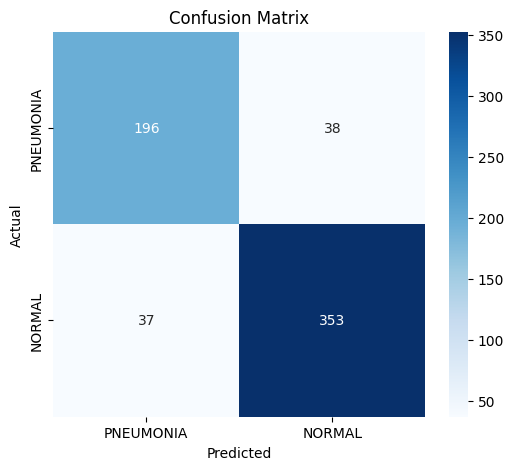

In [11]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()